# MDS plots of WT, bri1-T and pGL2-BRI1-GFP/bri1-T for cortex and atrichoblasts

In [1]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(muscat)
library(purrr)
library(limma)
library(scran)
library(future)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex hea

In [2]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/tmnolan7/anaconda3/envs/r_4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] patchwork_1.1.0             future_1.22.1              
 [3] scran_1.16.0                SingleCellExperiment_1.12.0
 [5] SummarizedExperiment_1.20.0 Biobase_2.50.0             
 [7] GenomicRanges_1.42.0        GenomeInfoDb_1.26.7        
 [9] IRanges_2.24.1   

In [3]:
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

In [4]:
rc.integrated <- readRDS("../data/integrations/rc.integrated_15S_BRZ_bri1_Li_seu3_clean.rds")

In [5]:
integrated.de <- subset(rc.integrated, subset = sample %in% c("sc_130", "sc_131","sc_133", "sc_134", "sc_135","sc_137"))
integrated.de <- subset(integrated.de, subset = cell_type %in% c("Cortex"))

In [6]:
integrated.de

An object of class Seurat 
71252 features across 4391 samples within 3 assays 
Active assay: integrated (17338 features, 17338 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

## Convert to sce

In [7]:
#  construct sce manually
my_metadata <- data.frame(sample_id = integrated.de$sample,
                              group_id = integrated.de$genotype,
                              cluster_id = integrated.de$cell_type, 
                             date=integrated.de$rep) # include experimental rep as co-variate

sce <- SingleCellExperiment(assays = list(counts = integrated.de@assays$RNA@counts),
	                            colData = my_metadata)

(sce <- prepSCE(sce, 
        kid = "cluster_id", # subpopulation assignments
        gid = "group_id",   # group IDs (ctrl/stim)
        sid = "sample_id",    # sample IDs (ctrl/stim.1234)
        drop = FALSE))        # drop all other colData columns

class: SingleCellExperiment 
dim: 29347 4391 
metadata(1): experiment_info
assays(1): counts
rownames(29347): AT1G01010 AT1G01020 ... AT5G53640 AT5G60260
rowData names(0):
colnames(4391): AAACCCAGTCTGGTTA_8 AAACGCTGTGAGATCG_8 ...
  TTTAGTCCACTCAAGT_15 TTTCCTCAGCCGCACT_15
colData names(4): cluster_id sample_id group_id date
reducedDimNames(0):
altExpNames(0):

## pre-filtering

In [8]:
# remove undetected genes
sce <- sce[rowSums(counts(sce) > 0) > 0, ]
dim(sce)

[1] 24353  4391

In [9]:
# remove lowly expressed genes
sce <- sce[rowSums(counts(sce) > 1) >= 1, ]
dim(sce)

[1] 20013  4391

In [10]:
pb <- aggregateData(sce,
    assay = "counts", fun = "sum",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation
assayNames(pb)

[1] "Cortex"

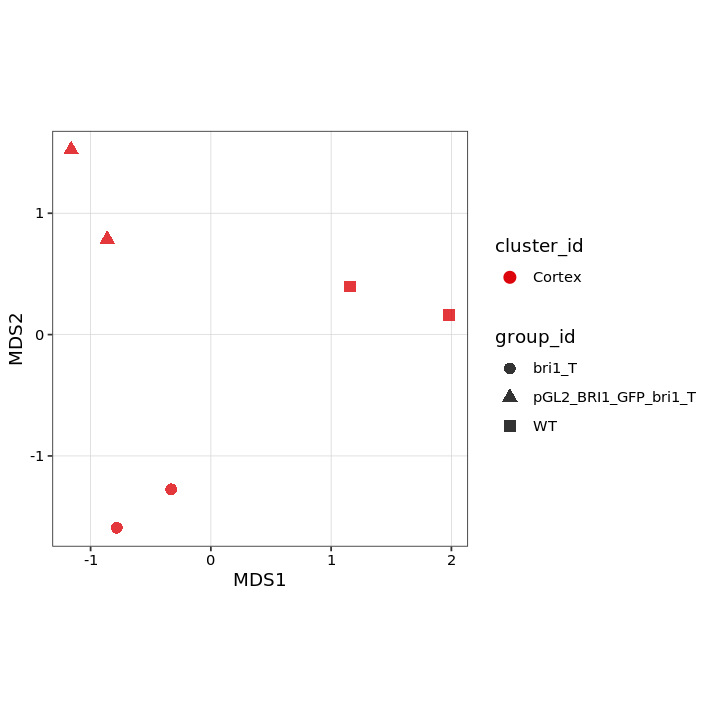

In [11]:
options(repr.plot.width=6, repr.plot.height=6)
(cortex_mds <- pbMDS(pb))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



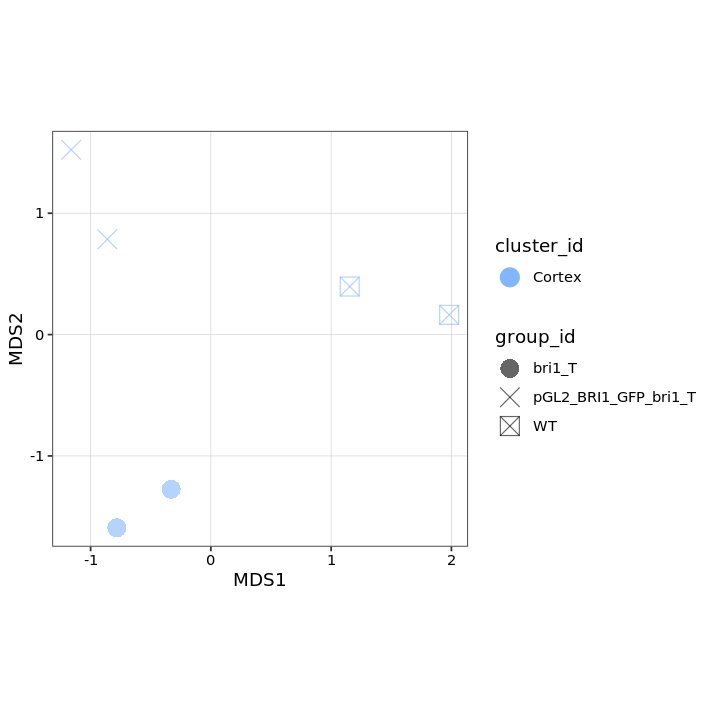

In [12]:
# use very distinctive shaping of groups & change cluster colors
cortex_mds_mod <- cortex_mds + 
  scale_shape_manual(values = c(16, 4,7)) +
  scale_color_manual(values = "#82B6FF")
# change point size & alpha
cortex_mds_mod$layers[[1]]$aes_params$size <- 5
cortex_mds_mod$layers[[1]]$aes_params$alpha <- 0.6
cortex_mds_mod

In [13]:
integrated.de <- subset(rc.integrated, subset = sample %in% c("sc_130", "sc_131","sc_133", "sc_134", "sc_135","sc_137"))
integrated.de <- subset(integrated.de, subset = cell_type %in% c("Atrichoblast"))

In [14]:
table(integrated.de$genotype, integrated.de$sample)

                      
                       sc_130 sc_131 sc_133 sc_134 sc_135 sc_137
  bri1_T                    0   1441      0      0   1039      0
  pGL2_BRI1_GFP_bri1_T      0      0    930      0      0    312
  WT                     1446      0      0   1172      0      0

## Convert to sce

In [15]:
#  construct sce manually
my_metadata <- data.frame(sample_id = integrated.de$sample,
                              group_id = integrated.de$genotype,
                              cluster_id = integrated.de$cell_type, 
                             date=integrated.de$rep) # include experimental rep as co-variate

sce <- SingleCellExperiment(assays = list(counts = integrated.de@assays$RNA@counts),
	                            colData = my_metadata)

(sce <- prepSCE(sce, 
        kid = "cluster_id", # subpopulation assignments
        gid = "group_id",   # group IDs (ctrl/stim)
        sid = "sample_id",    # sample IDs (ctrl/stim.1234)
        drop = FALSE))        # drop all other colData columns

class: SingleCellExperiment 
dim: 29347 6340 
metadata(1): experiment_info
assays(1): counts
rownames(29347): AT1G01010 AT1G01020 ... AT5G53640 AT5G60260
rowData names(0):
colnames(6340): AAACCCACAACAGCCC_8 AAACCCACAGCTGTCG_8 ...
  TTTCCTCAGACGTCCC_15 TTTGGAGGTGGACCAA_15
colData names(4): cluster_id sample_id group_id date
reducedDimNames(0):
altExpNames(0):

## pre-filtering

In [16]:
# remove undetected genes
sce <- sce[rowSums(counts(sce) > 0) > 0, ]
dim(sce)

[1] 24786  6340

In [17]:
# remove lowly expressed genes
sce <- sce[rowSums(counts(sce) > 1) >= 1, ]
dim(sce)

[1] 20468  6340

In [18]:
nk <- length(kids <- levels(sce$cluster_id))
ns <- length(sids <- levels(sce$sample_id))
names(kids) <- kids; names(sids) <- sids

In [19]:
# nb. of cells per cluster-sample
t(table(sce$cluster_id, sce$sample_id))

        
         Quiescent Center Columella Lateral Root Cap Atrichoblast Trichoblast
  sc_130                0         0                0         1446           0
  sc_131                0         0                0         1441           0
  sc_133                0         0                0          930           0
  sc_134                0         0                0         1172           0
  sc_135                0         0                0         1039           0
  sc_137                0         0                0          312           0
        
         Cortex Endodermis Phloem Xylem Procambium Pericycle
  sc_130      0          0      0     0          0         0
  sc_131      0          0      0     0          0         0
  sc_133      0          0      0     0          0         0
  sc_134      0          0      0     0          0         0
  sc_135      0          0      0     0          0         0
  sc_137      0          0      0     0          0         0

In [20]:
pb <- aggregateData(sce,
    assay = "counts", fun = "sum",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation
assayNames(pb)

[1] "Atrichoblast"

In [21]:
# pseudobulks for 1st subpopulation
t(head(assay(pb)))

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060
sc_130,474,440,0,32,4940,8
sc_131,242,640,2,51,7599,29
sc_133,215,442,9,47,4691,19
sc_134,445,374,7,36,4134,15
sc_135,210,531,9,46,6806,32
sc_137,172,269,7,23,2296,15


In [22]:
pb

class: SingleCellExperiment 
dim: 20468 6 
metadata(3): experiment_info agg_pars n_cells
assays(1): Atrichoblast
rownames(20468): AT1G01010 AT1G01020 ... AT3G43990 ATMG09960
rowData names(0):
colnames(6): sc_130 sc_131 ... sc_135 sc_137
colData names(2): group_id date
reducedDimNames(0):
altExpNames(0):

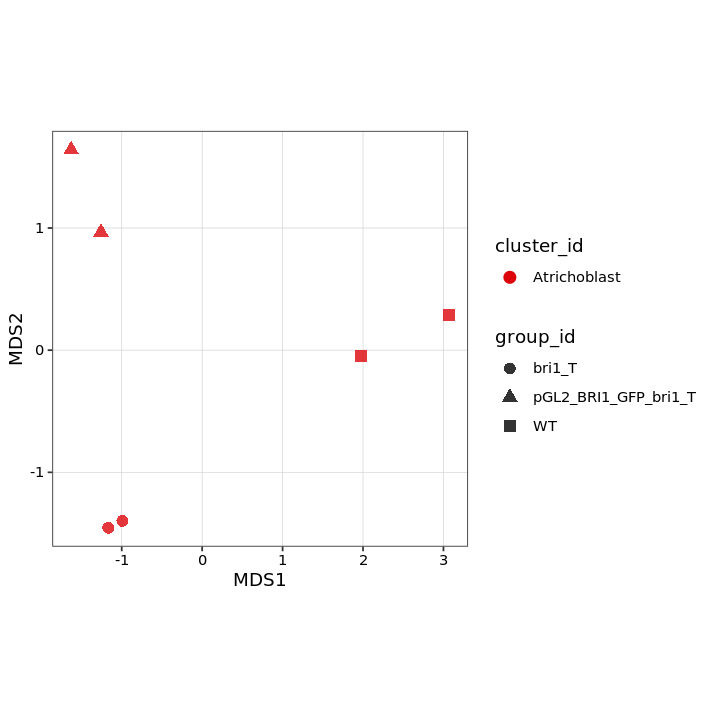

In [23]:
options(repr.plot.width=6, repr.plot.height=6)
(at_mds <- pbMDS(pb))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



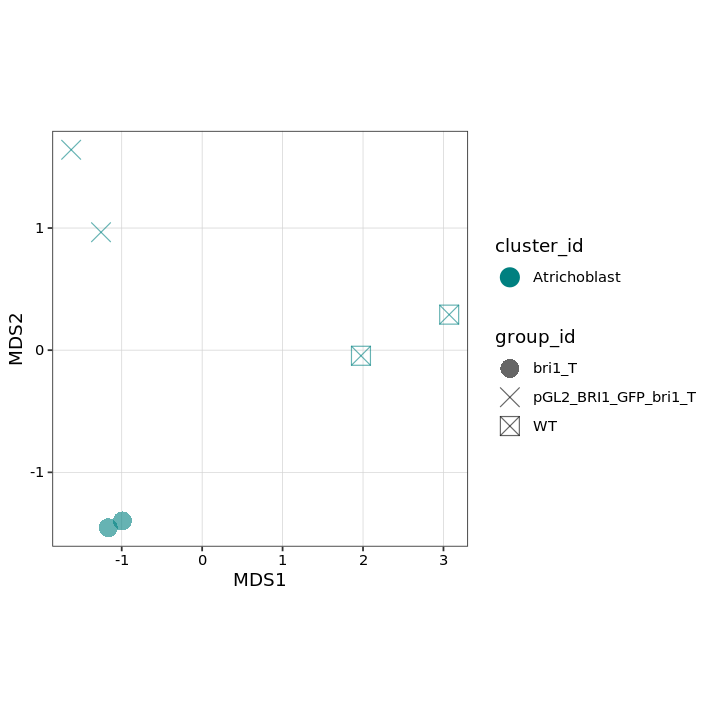

In [24]:
# use very distinctive shaping of groups & change cluster colors
at_mds_mod <- at_mds + 
  scale_shape_manual(values = c(16, 4,7)) +
  scale_color_manual(values = "#008080")
# change point size & alpha
at_mds_mod$layers[[1]]$aes_params$size <- 5
at_mds_mod$layers[[1]]$aes_params$alpha <- 0.6
at_mds_mod

ERROR: Error in grDevices::pdf(file = filename, ..., version = version): cannot open file './output/bri1_T_DE/WT_bri1_GL2_cotex_atricho_MDS.pdf'


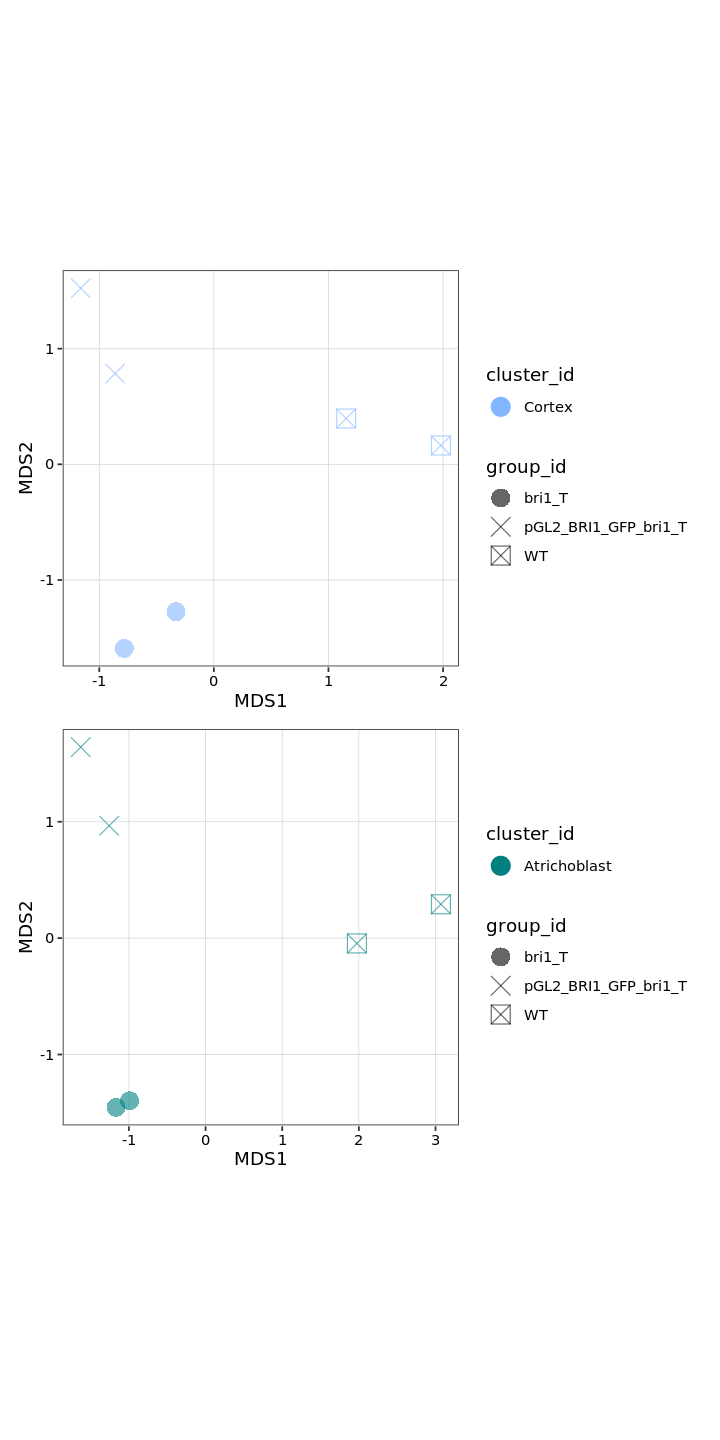

In [25]:
options(repr.plot.width=6, repr.plot.height=12)

cortex_mds_mod + at_mds_mod + plot_layout(ncol=1)

ggsave("./output/bri1_T_DE/WT_bri1_GL2_cotex_atricho_MDS.pdf", width = 6, height = 12)